In [23]:
import re
import pandas as pd
from typing import  Literal,List,Any, Optional, Tuple
from langchain_core.tools import tool
from langgraph.types import Command
from langgraph.graph.message import add_messages,BaseMessage
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts.chat import ChatPromptTemplate
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, field_validator
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

# GOOGLE_API_Key=os.getenv("GOOGLE_API_KEY")
# os.environ["GOOGLE_API_KEY"]=GOOGLE_API_Key
# llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")


True

In [24]:
import os
GROK=os.getenv("GROK")
os.environ["GROK"]=GROK


In [25]:
llm=ChatGroq(model="llama-3.1-8b-instant", api_key= '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')


In [26]:
llm.invoke("hi")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.010666667, 'prompt_time': 0.006795093, 'queue_time': 0.399192663, 'total_time': 0.01746176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8d1c73bd4c', 'finish_reason': 'stop', 'logprobs': None}, id='run--40e77fa6-f030-400f-b7ca-12163bfc83d5-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [27]:
# Pydantic models for input validation
class DateTimeModel(BaseModel):
    date: str = Field(description="Properly formatted date and time", pattern=r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$', v):
            raise ValueError("The date should be in format 'YYYY-MM-DD HH:MM'")
        return v

class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{4}-\d{2}-\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{4}-\d{2}-\d{2}$', v):
            raise ValueError("The date must be in the format 'YYYY-MM-DD'")
        return v

class IdentificationNumberModel(BaseModel):
    id: int = Field(description="Identification number (7 or 8 digits long)")
    
    @field_validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)):
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v


In [28]:
class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{4}-\d{2}-\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{4}-\d{2}-\d{2}$', v):
            raise ValueError("The date must be in the format 'YYYY-MM-DD'")
        return v

# Updated check_room_availability function with optional parameters
@tool
def check_room_availability(
    desired_date: DateModel,
    min_capacity: Optional[int] = None,
    projector: Optional[bool] = None,
    whiteboard: Optional[bool] = None,
    video_conferencing: Optional[bool] = None,
    wheelchair_accessible: Optional[bool] = None
) -> str:
    """
    Check availability of meeting rooms on a specific date, filtering by capacity and features.
    Parameters are optional except for desired_date. If a parameter is None, no filter is applied for that criterion.
    """
    rooms_df = pd.read_csv("data/meeting_rooms.csv")
    bookings_df = pd.read_csv("data/bookings.csv")
    
    # Filter rooms by features and capacity
    filtered_rooms = rooms_df.copy()
    
    if min_capacity is not None:
        filtered_rooms = filtered_rooms[filtered_rooms['capacity'] >= min_capacity]
    
    if projector is not None:
        filtered_rooms = filtered_rooms[filtered_rooms['projector'] == ('yes' if projector else 'no')]
    
    if whiteboard is not None:
        filtered_rooms = filtered_rooms[filtered_rooms['whiteboard'] == ('yes' if whiteboard else 'no')]
    
    if video_conferencing is not None:
        filtered_rooms = filtered_rooms[filtered_rooms['video_conferencing'] == ('yes' if video_conferencing else 'no')]
    
    if wheelchair_accessible is not None:
        filtered_rooms = filtered_rooms[filtered_rooms['wheelchair_accessible'] == ('yes' if wheelchair_accessible else 'no')]
    
    if filtered_rooms.empty:
        return "No rooms match the specified criteria."
    
    # Check bookings for the desired date
    bookings_df['start_time'] = pd.to_datetime(bookings_df['start_time'], format='%Y-%m-%d %H:%M')
    bookings_df['end_time'] = pd.to_datetime(bookings_df['end_time'], format='%Y-%m-%d %H:%M')
    desired_date = pd.to_datetime(desired_date.date, format='%Y-%m-%d')
    
    booked_rooms = bookings_df[
        (bookings_df['start_time'].dt.date == desired_date.date())
    ]['room_id'].unique()
    
    # Find available rooms
    available_rooms = filtered_rooms[~filtered_rooms['room_id'].isin(booked_rooms)]
    
    if available_rooms.empty:
        output = f"No available rooms on {desired_date.date} matching the criteria.\n"
        output += "Available rooms with different features:\n"
        all_available = rooms_df[~rooms_df['room_id'].isin(booked_rooms)]
        for _, row in all_available.iterrows():
            output += f"Room {row['room_id']} ({row['room_location']}): Capacity {row['capacity']}, "
            output += f"Projector: {row['projector']}, Whiteboard: {row['whiteboard']}, "
            output += f"Video Conferencing: {row['video_conferencing']}, Wheelchair Accessible: {row['wheelchair_accessible']}\n"
        return output
    
    output = f"Available rooms on {desired_date.date}:\n"
    for _, row in available_rooms.iterrows():
        output += f"Room {row['room_id']} ({row['room_location']}): Capacity {row['capacity']}, "
        output += f"Projector: {row['projector']}, Whiteboard: {row['whiteboard']}, "
        output += f"Video Conferencing: {row['video_conferencing']}, Wheelchair Accessible: {row['wheelchair_accessible']}\n"
    return output

In [29]:
date_instance = DateModel(date="2025-05-17")
print(date_instance)

print(check_room_availability.invoke({
    "desired_date": date_instance,
    "min_capacity": 10,
    "projector": True,
    "video_conferencing": True
}))

date='2025-05-17'
Available rooms on <bound method Timestamp.date of Timestamp('2025-05-17 00:00:00')>:
Room 2 (Building A - Floor 2): Capacity 20, Projector: yes, Whiteboard: yes, Video Conferencing: yes, Wheelchair Accessible: no
Room 5 (Building C - Floor 1): Capacity 30, Projector: yes, Whiteboard: yes, Video Conferencing: yes, Wheelchair Accessible: yes
Room 7 (Building A - Floor 3): Capacity 25, Projector: yes, Whiteboard: no, Video Conferencing: yes, Wheelchair Accessible: yes
Room 8 (Building B - Floor 2): Capacity 18, Projector: yes, Whiteboard: yes, Video Conferencing: yes, Wheelchair Accessible: no



In [30]:
@tool
def book_room(room_id: int, customer_name: str, start_time: DateTimeModel, end_time: DateTimeModel, customer_id: IdentificationNumberModel) -> str:
    """
    Book a meeting room for a specific time slot, including customer ID in the booking.
    """
    bookings_df = pd.read_csv("data/bookings.csv")
    
    # Validate time format
    start_dt = pd.to_datetime(start_time.date, format='%Y-%m-%d %H:%M')
    end_dt = pd.to_datetime(end_time.date, format='%Y-%m-%d %H:%M')
    
    if start_dt >= end_dt:
       return "End time must be after start time."
    
    # Check for scheduling conflicts
    conflicting_bookings = bookings_df[
        (bookings_df['room_id'] == room_id) &
        (pd.to_datetime(bookings_df['start_time'], format='%Y-%m-%d %H:%M') < end_dt) &
        (pd.to_datetime(bookings_df['end_time'], format='%Y-%m-%d %H:%M') > start_dt)
    ]
    
    if not conflicting_bookings.empty:
        return f"Room {room_id} is already booked during the requested time slot."
    
    # Add new booking with customer_id
    new_booking = pd.DataFrame([{
        'room_id': room_id,
        'customer_name': customer_name,
        'customer_id': customer_id.id,
        'start_time': start_time.date,
        'end_time': end_time.date
    }])
    bookings_df = pd.concat([bookings_df, new_booking], ignore_index=True)
    bookings_df.to_csv("data/bookings.csv", index=False)
    
    return f"Successfully booked Room {room_id} for {customer_name} from {start_time.date} to {end_time.date}."



In [31]:
start_time = DateTimeModel(date="2025-05-18 09:00")
end_time = DateTimeModel(date="2025-05-18 10:30")
customer_id = IdentificationNumberModel(id=10000002)
print(book_room.invoke({
    "room_id": 3,
    "customer_name": "sameh",
    "start_time": start_time,
    "end_time": end_time,
    "customer_id": customer_id
}))

Room 3 is already booked during the requested time slot.


In [32]:
@tool
def cancel_booking(room_id: int, customer_id: IdentificationNumberModel, start_time: DateTimeModel) -> str:
    """
    Cancel a meeting room booking by room ID, customer ID, and start time.
    """
    bookings_df = pd.read_csv("data/bookings.csv")
    
    # Find the booking
    booking = bookings_df[
        (bookings_df['room_id'] == room_id) &
        (bookings_df['customer_id'] == customer_id.id) &
        (bookings_df['start_time'] == start_time.date)
    ]
    
    if booking.empty:
        return f"No booking found for Room {room_id} with customer ID {customer_id.id} at {start_time.date}."
    
    # Remove the booking
    bookings_df = bookings_df[
        ~((bookings_df['room_id'] == room_id) &
          (bookings_df['customer_id'] == customer_id.id) &
          (bookings_df['start_time'] == start_time.date))
    ]
    bookings_df.to_csv("data/bookings.csv", index=False)
    
    return f"Successfully canceled booking for Room {room_id} at {start_time.date}."


In [33]:
start_time = DateTimeModel(date="2025-05-15 09:00")
customer_id = IdentificationNumberModel(id=12345678)
print(cancel_booking.invoke({
    "room_id": 1,
    "customer_id": customer_id,
    "start_time": start_time
}))

No booking found for Room 1 with customer ID 12345678 at 2025-05-15 09:00.


In [34]:

@tool
def reschedule_booking(

    old_date: DateTimeModel,

    new_date: Tuple[DateTimeModel, DateTimeModel],

    customer_id: IdentificationNumberModel

) -> str:

    """

    Reschedule a meeting room booking by canceling the existing booking and creating a new one.

    Parameters:

    - old_date: Start time of the existing booking (YYYY-MM-DD HH:MM).

    - new_date: Tuple of (start_time, end_time) for the new booking (YYYY-MM-DD HH:MM).

    - customer_id: Customer's identification number (7 or 8 digits).

    """

    bookings_df = pd.read_csv("data/bookings.csv")

    # Find the existing booking

    booking = bookings_df[

        (bookings_df['customer_id'] == customer_id.id) & (bookings_df['start_time'] == old_date.date)

    ]


    if booking.empty:
        return f"No booking found for customer ID {customer_id.id} at {old_date.date}."

    

    # Extract details of the existing booking

    room_id = booking.iloc[0]['room_id']

    customer_name = booking.iloc[0]['customer_name']

    

    # Cancel the existing booking

    cancel_result = cancel_booking.invoke({

        "room_id": room_id,

        "customer_id": customer_id,

        "start_time": old_date

    })

    

    if "No booking found" in cancel_result:

        return cancel_result  # Cancellation failed, return the error

    

    # Book the new time slot

    new_start_time, new_end_time = new_date

    book_result = book_room.invoke({

        "room_id": room_id,

        "customer_name": customer_name,

        "start_time": new_start_time,

        "end_time": new_end_time,

        "customer_id": customer_id

    })

    

    if "Successfully booked" in book_result:

        return f"Successfully rescheduled booking for Room {room_id} from {old_date.date} to {new_start_time.date}–{new_end_time.date}."

    else:

        # If booking fails, return the error (e.g., conflict or invalid time)

        return f"Failed to reschedule: {book_result}"


In [35]:
old_date = DateTimeModel(date="2025-05-18 09:00")
new_start_time = DateTimeModel(date="2025-05-19 10:00")
new_end_time = DateTimeModel(date="2025-05-19 11:30")
customer_id = IdentificationNumberModel(id=10000001)
print(reschedule_booking.invoke({
    "old_date": old_date,
    "new_date": (new_start_time, new_end_time),
    "customer_id": customer_id
}))

No booking found for customer ID 10000001 at 2025-05-18 09:00.


In [36]:
# Router and AgentState definitions

class Router(TypedDict):

    next: Literal["information_node", "booking_node", "FINISH"]

    reasoning: str



class AgentState(TypedDict):

    messages: Annotated[list[Any], add_messages]

    id_number: int

    next: str

    query: str

    current_reasoning: str



# Updated members_dict for meeting room booking system

members_dict = {

    'information_node': 'Specialized agent to provide information about meeting room availability and features.',

    'booking_node': 'Specialized agent to book, cancel, or reschedule meeting room bookings.'

}



# Options for routing

options = list(members_dict.keys()) + ["FINISH"]


# Worker information for system prompt

worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If the user query is fully answered, route to Finished'

print(worker_info)


WORKER: information_node 
DESCRIPTION: Specialized agent to provide information about meeting room availability and features.

WORKER: booking_node 
DESCRIPTION: Specialized agent to book, cancel, or reschedule meeting room bookings.

WORKER: FINISH 
DESCRIPTION: If the user query is fully answered, route to Finished


In [ ]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers. "
    "### SPECIALIZED ASSISTANTS:\n"
    f"{worker_info}\n\n"
    "Your primary role is to assist users in managing meeting room bookings, including checking room availability, booking, canceling, or rescheduling. "
    "If a user requests information about room availability or features, delegate to the information_node. "
    "If a user requests to book, cancel, or reschedule a room, delegate to the booking_node. "
    "Given the user request, respond with the worker to act next. Each worker will perform a task and respond with their results. "
    "When the query is fully answered, respond with FINISH. "
    "Utilize the conversation history to assess if the query is resolved, then route to FINISH. "
    "Always consider the current year is 2025 for date-related queries."
)

In [49]:
# Supervisor node
def supervisor_node(state: AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    print(state)
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    query = ''
    if len(state['messages']) == 1:
        query = state['messages'][0].content
      
    print("************below is my query********************")    
    print(query)
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    print(response["reasoning"])
          
    if goto == "FINISH":
        goto = END
        
    print("**************************below is my state****************************")
    print(state)
    
    if query:
        return Command(goto=goto, update={
            'next': goto,
            'query': query,
            'current_reasoning': response["reasoning"],
            'messages': [HumanMessage(content=f"user's identification number is {state['id_number']}")]
        })
    return Command(goto=goto, update={
        'next': goto,
        'current_reasoning': response["reasoning"]
    })

# Information node
def information_node(state: AgentState) -> Command[Literal['supervisor']]:
    print("*****************called information node************")
    
    system_prompt = (
        "You are a specialized agent to provide information about meeting room availability and features based on the query. "
        "You have access to the check_room_availability tool. "
        "Make sure to ask the user politely if you need further information to execute the tool. "
        "Always consider the current year is 2025 for date-related queries."
    )
    
    system_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("placeholder", "{messages}")
    ])
    
    information_agent = create_react_agent(
        model=llm,
        tools=[check_room_availability],
        prompt=system_prompt
    )
    
    result = information_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor"
    )

# Booking node
def booking_node(state: AgentState) -> Command[Literal['supervisor']]:
    print("*****************called booking node************")
    
    system_prompt = (
        "You are a specialized agent to book, cancel, or reschedule meeting room bookings based on the query. "
        "You have access to the book_room, cancel_booking, and reschedule_booking tools. "
        "Make sure to ask the user politely if you need further information to execute the tools. "
        "Always consider the current year is 2025 for date-related queries."
    )
    
    system_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("placeholder", "{messages}")
    ])
    
    booking_agent = create_react_agent(
        model=llm,
        tools=[book_room, cancel_booking, reschedule_booking,],
        prompt=system_prompt
    )
    
    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor"
    )


In [50]:
# Build the graph
graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_node)
graph.add_node("information_node", information_node)
graph.add_node("booking_node", booking_node)
graph.add_edge(START, "supervisor")

# Compile the graph
app = graph.compile()


In [51]:
import langgraph

graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='supervisor', data=None, conditional=False), Edge(source='booking_node', target='supervisor', data=None, conditional=True), Edge(source='information_node', target='supervisor', data=None, conditional=True), Edge(sou

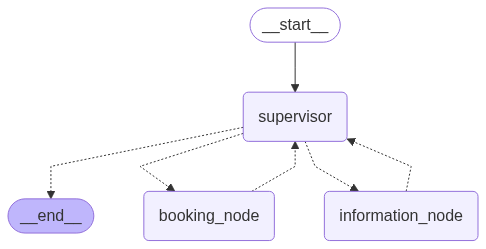

In [52]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [53]:
inputs = [
    HumanMessage(content='Can you check and make a booking for a meeting room with a projector on 2025-05-19 at 10:00 AM for 1 hour?')
]

In [54]:
state = {
    "messages": inputs,
    "id_number": 10000001,
    "customer_name": "abdelrhman",
    "next": "",
    "query": "",
    "current_reasoning": ""
}


In [ ]:
result = app.invoke(state)


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='Can you check and make a booking for a meeting room with a projector on 2025-05-19 at 10:00 AM for 1 hour?', additional_kwargs={}, response_metadata={}, id='492e2063-48f5-4156-9497-894bc33e645d')], 'id_number': 10000001, 'next': '', 'query': '', 'current_reasoning': ''}
***********************this is my message*****************************************
[{'role': 'system', 'content': 'You are a supervisor tasked with managing a conversation between the following workers. ### SPECIALIZED ASSISTANTS:\nWORKER: information_node \nDESCRIPTION: Specialized agent to provide information about meeting room availability and features.\n\nWORKER: booking_node \nDESCRIPTION: Specialized agent to book, cancel, or reschedule meeting room bookings.\n\nWORKER: FINISH \nDESCRIPTION: If the user query is fully answered, route to Finished\n\nYour primary role is to assist users in